# Negative Binomial Regression for Entire City
The purpose of this notebook is to perform a series of logistic regression models following our conceptual analysis model. For each of the 10 SoP variables, we will perform a univariate logit, followed by multivariate models of the SoP variable and increasing numbers of control variables. An example process follows:
1. Collision_occured(binary dependent variable) = FORM3(SoP independent variable)
2. Collision_occured(DV) = FORM3(IV) + Residential_Population(first control variable)
3. Collision_occured(DV) = FORM3(IV) + Residential_Population(CV) + Number_Travel_Lanes(2nd CV)
...
4. Collision_occured(DV) = FORM3(IV) + (Residential_Population + Number_Travel_Lanes + Work_Population + Distance_to_Subway + ...)

This will be followed by a multivariate model combining all 10 SoP Variables and a similar sequential addition of control variables. The final output will be a table summarizing all of the above with associate $R^2$ & *coeficients* for each model

In [1]:
import os
import pandas as pd
import numpy as np

from scipy.stats.distributions import chi2

pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 150)

from IPython.core.interactiveshell import InteractiveShell

from statsmodels.api import Logit, add_constant
import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler

from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics

#import xgboost as xgb

import matplotlib.pyplot as plt
%matplotlib inline

### Part 0: Ingest and Encode Dependent, Independent, and Control Variables

In [2]:
intersections = pd.read_csv('../Data/road_network_data/osm/intersections_final_w_sop/intersections_final.csv')
intersections.head()

,osmid,Total_Inju,Total_Fata,sub_dist,med_inc,norm_res_p,norm_work_,geometry,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,FORM3,DENS2,CONN5,PROX3,PARKS2,PAF2,PEDS3,TRAFFIC5,AESTTOT3,SAFE,SoPIndex6,FORM3_norm,DENS2_norm,CONN5_norm,PROX3_norm,PARKS2_norm,PAF2_norm,PEDS3_norm,TRAFFIC5_norm,AESTTOT3_norm,SAFE_norm,SoPIndex6_norm,Collisions,Collision_Occured
0,42860546,0.0,0.0,1.371429,13.714700,18.525176,0.382706,POINT (1000750.795416632 210205.7528114537),4.0,1.5,2.0,25.0,3.0,40.75,-7.809492,1.793260,-1.056529,0.088352,-1.395603,-0.458275,7.286847,7.465677,6.991727,-6.980700,5.925263,2.249382,59.628458,53.615492,6.600246,0.143733,0.005288,25.162572,64.023970,38.010729,73.023619,39.290709,0.0,0
1,42467330,2.0,0.0,4.582604,4.004433,48.649265,1.256099,POINT (1002652.742108569 177974.3482433519),4.0,2.0,2.0,25.0,0.0,40.00,-3.484622,3.718840,-0.931710,-2.673075,-1.395603,-0.458275,2.801236,7.233681,2.836356,1.412148,9.058976,10.549486,71.300206,53.962696,3.457195,0.143733,0.005288,20.480076,63.564348,33.826127,91.887175,40.444334,2.0,1
2,42467331,1.0,0.0,4.416357,3.880400,57.305828,1.048126,POINT (1002921.868557178 177996.4131735155),4.0,1.5,2.0,25.0,0.0,33.50,-3.544449,2.147821,-1.056529,-4.368950,-1.395603,-0.458275,2.801236,7.465677,3.833468,-0.020003,5.404393,10.434668,61.777602,53.615492,1.526952,0.143733,0.005288,20.480076,64.023970,34.830253,88.668309,39.098959,1.0,1
3,42467333,1.0,0.0,4.247996,5.534925,68.654563,1.268928,POINT (1003181.00656743 178017.3803186663),4.0,1.5,2.0,25.0,0.0,33.00,-3.544449,3.121916,-1.056529,-2.243159,-1.395603,-0.458275,2.333350,7.465677,3.833468,0.151996,8.208391,10.434668,67.682000,53.615492,3.946524,0.143733,0.005288,19.991653,64.023970,34.830253,89.054888,40.131205,1.0,1
4,42467334,23.0,0.0,4.077225,6.210467,63.780911,1.550502,POINT (1003459.565062104 178040.5515355509),4.0,3.0,2.0,25.0,0.0,50.00,0.623103,3.611247,0.165412,7.982746,-1.395603,-0.458275,4.453216,8.519762,3.773186,-4.944856,22.329938,18.432852,70.648042,57.014531,15.585632,0.143733,0.005288,22.204565,66.112289,34.769547,77.599332,45.329821,23.0,1


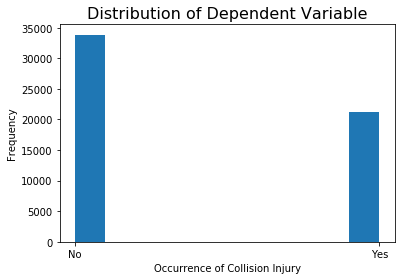

In [3]:
# Look at distribution of DV throughout city
plt.figure(figsize=(6,4))
plt.hist(intersections.Collision_Occured)
plt.title('Distribution of Dependent Variable', fontsize=16)
plt.xticks(range(2), labels=['No', 'Yes'])
plt.xlabel('Occurrence of Collision Injury')
plt.ylabel('Frequency')
plt.show()

In [4]:
# we will look at each of the following individually at first
ind_variables = ['FORM3_norm', 'DENS2_norm', 'CONN5_norm', 'PROX3_norm', 'PARKS2_norm', 
                 'PAF2_norm', 'PEDS3_norm', 'TRAFFIC5_norm', 'AESTTOT3_norm', 'SAFE_norm']

# these are our OPTIONAL control variables, i.e. we do not have to use all of them
# I've ordered them in order of importance
control_variables = ['med_inc', 'norm_res_p', 'norm_work_', 'sub_dist',
                     'Num_Streets', 'Num_Lanes','Num_Park_Lanes', 'Speed_Limit', 'Bike_Lanes', 'Street_Width']

In [5]:
# scale entire dataset
ind_cv = ['SoPIndex6_norm'] + ind_variables + control_variables
X_2 = intersections[ind_cv]

# dependent
y = intersections.Collision_Occured

### Part 1: Repeat Process using Negative Binomial

In [9]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [10]:
# Encode dependent variable as continuous
y2 = intersections.Collisions

In [24]:
report_negbin = pd.DataFrame(columns=['Model', 'r2'] + X_2.columns.tolist())
models_negbin = {}

In [25]:
def negativeBinomialReport(x_list, model_name, y=y2, X=X_2, report=report_negbin, add_const=True):
    """
    Run negative binomial regression and append result to the report
    
    input:
    x_list: a list of covariates
    model_name: a name for the model
    y: a dataframe for dependent variable
    X: a data frame for all independent variables
    report: a report dataframe to append on

    
    return: a new appended report dataframe
    """
    
    if add_const:
        X = add_constant(X.reindex(columns=x_list))
    else:
        X = X.reindex(columns=x_list)
    
    model = NegativeBinomial(y, X).fit()
    report = report.append(pd.concat([pd.Series({'Model': model_name, 'r2': round(model.prsquared, 3)}), round(model.params, 3)], axis=0).rename('coef'))
    report = report.append(pd.concat([pd.Series({'Model': model_name, 'r2': round(model.prsquared, 3)}), round(model.pvalues, 3)], axis=0).rename('pvalue'))
    
    models_negbin[model_name] = model
    
    return report

def getSignificance(df):
    dfT = df.T
    dfT.loc[dfT.index != 'r2','coef'] = dfT.loc[dfT.index != 'r2',:].apply(
        lambda x: ''.join([x['coef'].astype(str), '***']) if x['pvalue'] < 0.001 else \
            (''.join([x['coef'].astype(str), '**']) if x['pvalue'] < 0.01 else \
            (''.join([x['coef'].astype(str), '*']) if x['pvalue'] < 0.05 else x['coef'])), axis=1)
    
    dfT.drop('pvalue', axis=1, inplace=True)
    return dfT.T

def formatReport(report, variable, compare='start'):
    cols=list(report.columns)
    if compare == 'start':
        rep = report[report.Model.str.startswith(variable)].groupby('Model').apply(getSignificance)
    else:
        rep = report[report.Model.str.endswith(variable)].groupby('Model').apply(getSignificance)                                   
    cols.remove('Model')
    rep = rep[cols]
    rep.dropna(axis=1, how='all', inplace=True)
    rep.fillna('', inplace=True)
    rep.index = rep.index.droplevel(1)
    
    return rep

In [26]:
%%capture 
# above is so we do not print results

# First, univariate models w/out CV's
for idx, field in enumerate(['SoPIndex6_norm'] + ind_variables):
    report_negbin = negativeBinomialReport(x_list=[field], model_name=field, report=report_negbin)

In [28]:
formatReport(report_negbin, 'norm', 'end').sort_values(['SoPIndex6_norm'] + ind_variables, ascending=False)

,r2,SoPIndex6_norm,FORM3_norm,DENS2_norm,CONN5_norm,PROX3_norm,PARKS2_norm,PAF2_norm,PEDS3_norm,TRAFFIC5_norm,AESTTOT3_norm,SAFE_norm,alpha,const
Model,,,,,,,,,,,,,,
SoPIndex6_norm,0.033,0.126***,,,,,,,,,,,3.312***,-4.72***
FORM3_norm,0.004,,-0.047***,,,,,,,,,,4.107***,0.947***
DENS2_norm,0.002,,,0.011***,,,,,,,,,4.179***,-0.189***
CONN5_norm,0.000,,,,0.017***,,,,,,,,4.225***,-0.462*
PROX3_norm,0.055,,,,,0.145***,,,,,,,2.817***,-0.634***
PARKS2_norm,0.001,,,,,,0.019***,,,,,,4.211***,0.411***
PAF2_norm,0.007,,,,,,,0.099***,,,,,4.034***,0.368***
PEDS3_norm,0.031,,,,,,,,0.131***,,,,3.395***,-2.337***
TRAFFIC5_norm,0.001,,,,,,,,,0.022***,,,4.192***,-0.829***


In [29]:
%%capture 

# neg bins with increasing number of CV's 
for field in ['SoPIndex6_norm'] + ind_variables:
    for i in range(1, len(control_variables)+1): 
        report_negbin = negativeBinomialReport(x_list=[field]+ control_variables[:i], model_name=field+'_cv' + str(i).zfill(2), report=report_negbin)

In [31]:
InteractiveShell.ast_node_interactivity = "all"

# want to see how r2, coeff and significance changes with sample field
units = pd.read_csv('variables_units.csv', index_col='var').to_dict('index')

for field in ['SoPIndex6_norm'] + ind_variables:
    print('Results for all {} Univatiate Models'.format(units[field]['name']))
    formatReport(report_negbin, field)

Results for all SoP index Univatiate Models


,r2,SoPIndex6_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
SoPIndex6_norm,0.033,0.126***,,,,,,,,,,,3.312***,-4.72***
SoPIndex6_norm_cv01,0.040,0.136***,-0.081***,,,,,,,,,,3.14***,-4.623***
SoPIndex6_norm_cv02,0.056,0.103***,-0.065***,0.014***,,,,,,,,,2.828***,-4.034***
SoPIndex6_norm_cv03,0.060,0.083***,-0.085***,0.013***,0.026***,,,,,,,,2.741***,-3.184***
SoPIndex6_norm_cv04,0.067,0.077***,-0.072***,0.01***,0.021***,-0.062***,,,,,,,2.592***,-2.609***
SoPIndex6_norm_cv05,0.107,0.065***,-0.07***,0.007***,0.018***,-0.06***,1.055***,,,,,,1.977***,-5.828***
SoPIndex6_norm_cv06,0.145,0.086***,-0.065***,0.008***,0.007***,-0.056***,0.928***,0.667***,,,,,1.486***,-7.67***
SoPIndex6_norm_cv07,0.146,0.076***,-0.063***,0.008***,0.008***,-0.056***,0.91***,0.698***,0.197***,,,,1.473***,-7.62***
SoPIndex6_norm_cv08,0.146,0.074***,-0.062***,0.008***,0.008***,-0.056***,0.915***,0.729***,0.202***,-0.013***,,,1.469***,-7.286***


Results for all Form dimension Univatiate Models


,r2,FORM3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
FORM3_norm,0.004,-0.047***,,,,,,,,,,,4.107***,0.947***
FORM3_norm_cv01,0.006,-0.052***,-0.041***,,,,,,,,,,4.051***,1.258***
FORM3_norm_cv02,0.034,-0.007***,-0.029***,0.021***,,,,,,,,,3.331***,-0.217***
FORM3_norm_cv03,0.049,-0.003,-0.079***,0.017***,0.044***,,,,,,,,2.995***,-0.022
FORM3_norm_cv04,-0.515,-0.006***,-0.035***,0.008***,0.013***,-0.13***,,,,,,,0,0.757***
FORM3_norm_cv05,0.100,0.01***,-0.061***,0.01***,0.03***,-0.069***,1.102***,,,,,,2.098***,-3.638***
FORM3_norm_cv06,0.131,-0.006***,-0.055***,0.011***,0.02***,-0.067***,0.999***,0.64***,,,,,1.649***,-4.49***
FORM3_norm_cv07,0.136,-0.005**,-0.052***,0.01***,0.019***,-0.066***,0.94***,0.716***,0.443***,,,,1.585***,-5.155***
FORM3_norm_cv08,0.137,-0.004*,-0.052***,0.01***,0.018***,-0.064***,0.948***,0.788***,0.438***,-0.031***,,,1.567***,-4.527***


Results for all Density dimension Univatiate Models


,r2,DENS2_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
DENS2_norm,0.002,0.011***,,,,,,,,,,,4.179***,-0.189***
DENS2_norm_cv01,0.003,0.012***,-0.036***,,,,,,,,,,4.137***,-0.026
DENS2_norm_cv02,0.034,-0.005***,-0.025***,0.022***,,,,,,,,,3.326***,-0.03
DENS2_norm_cv03,0.050,-0.007***,-0.076***,0.019***,0.044***,,,,,,,,2.984***,0.327***
DENS2_norm_cv04,-0.514,-0.004,-0.031,0.008,0.013,-0.132,,,,,,,0,0.918
DENS2_norm_cv05,0.101,-0.01***,-0.06***,0.011***,0.03***,-0.07***,1.108***,,,,,,2.075***,-2.998***
DENS2_norm_cv06,0.134,0.014***,-0.057***,0.01***,0.019***,-0.065***,0.966***,0.73***,,,,,1.613***,-5.44***
DENS2_norm_cv07,0.137,0.007***,-0.054***,0.01***,0.019***,-0.065***,0.934***,0.748***,0.375***,,,,1.578***,-5.54***
DENS2_norm_cv08,0.138,0.006***,-0.053***,0.01***,0.018***,-0.064***,0.942***,0.811***,0.38***,-0.028***,,,1.563***,-4.906***


Results for all Connectivity dimension Univatiate Models


,r2,CONN5_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
CONN5_norm,0.000,0.017***,,,,,,,,,,,4.225***,-0.462*
CONN5_norm_cv01,0.001,0.02***,-0.032***,,,,,,,,,,4.191***,-0.418*
CONN5_norm_cv02,0.035,0.034***,-0.028***,0.021***,,,,,,,,,3.317***,-2.242***
CONN5_norm_cv03,0.049,0.017***,-0.078***,0.018***,0.043***,,,,,,,,2.991***,-1.034***
CONN5_norm_cv04,-0.514,0.017***,-0.033***,0.008***,0.013***,-0.131***,,,,,,,0,-0.268***
CONN5_norm_cv05,0.106,0.092***,-0.061***,0.01***,0.026***,-0.067***,1.197***,,,,,,1.971***,-9.006***
CONN5_norm_cv06,-0.193,-0.139***,-0.038***,0.006***,0.01***,-0.107***,0.81***,0.823***,,,,,0,3.81***
CONN5_norm_cv07,0.140,-0.128***,-0.051***,0.01***,0.019***,-0.068***,0.836***,0.993***,0.351***,,,,1.537***,1.84***
CONN5_norm_cv08,-0.170,-0.124,-0.037,0.005,0.009,-0.101,0.804,0.941,0.363,-0.034,,,0,3.076


Results for all Proximity dimension Univatiate Models


,r2,PROX3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
PROX3_norm,0.055,0.145***,,,,,,,,,,,2.817***,-0.634***
PROX3_norm_cv01,0.063,0.148***,-0.084***,,,,,,,,,,2.65***,-0.136***
PROX3_norm_cv02,0.080,0.122***,-0.07***,0.013***,,,,,,,,,2.383***,-0.648***
PROX3_norm_cv03,0.080,0.116***,-0.078***,0.013***,0.01***,,,,,,,,2.374***,-0.578***
PROX3_norm_cv04,-0.376,0.082,-0.066,0.03,0.014,-0.085,,,,,,,75.068,0.327
PROX3_norm_cv05,0.124,0.092***,-0.067***,0.008***,0.007***,-0.052***,0.997***,,,,,,1.75***,-3.648***
PROX3_norm_cv06,0.160,0.094***,-0.062***,0.009***,-0.001*,-0.048***,0.891***,0.624***,,,,,1.306***,-4.665***
PROX3_norm_cv07,0.161,0.089***,-0.061***,0.008***,-0.001,-0.048***,0.869***,0.663***,0.206***,,,,1.295***,-4.96***
PROX3_norm_cv08,0.162,0.088***,-0.061***,0.008***,-0.001,-0.048***,0.871***,0.685***,0.207***,-0.009***,,,1.294***,-4.785***


Results for all Parks dimension Univatiate Models


,r2,PARKS2_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
PARKS2_norm,0.001,0.019***,,,,,,,,,,,4.211***,0.411***
PARKS2_norm_cv01,0.002,0.02***,-0.032***,,,,,,,,,,4.176***,0.616***
PARKS2_norm_cv02,0.034,0.016***,-0.028***,0.021***,,,,,,,,,3.325***,-0.374***
PARKS2_norm_cv03,0.049,0.007***,-0.078***,0.017***,0.044***,,,,,,,,2.996***,-0.093***
PARKS2_norm_cv04,-0.516,-0,-0.033***,0.008***,0.013***,-0.131***,,,,,,,0,0.69***
PARKS2_norm_cv05,0.100,0.007***,-0.063***,0.01***,0.029***,-0.068***,1.101***,,,,,,2.099***,-3.54***
PARKS2_norm_cv06,0.131,-0.011***,-0.054***,0.011***,0.021***,-0.068***,0.994***,0.649***,,,,,1.642***,-4.521***
PARKS2_norm_cv07,0.136,-0.001,-0.051***,0.01***,0.019***,-0.066***,0.942***,0.714***,0.442***,,,,1.585***,-5.209***
PARKS2_norm_cv08,0.137,-0,-0.051***,0.01***,0.018***,-0.065***,0.95***,0.786***,0.438***,-0.031***,,,1.567***,-4.578***


Results for all Recreation dimension Univatiate Models


,r2,PAF2_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
PAF2_norm,0.007,0.099***,,,,,,,,,,,4.034***,0.368***
PAF2_norm_cv01,0.010,0.118***,-0.059***,,,,,,,,,,3.934***,0.722***
PAF2_norm_cv02,0.041,0.098***,-0.047***,0.02***,,,,,,,,,3.171***,-0.265***
PAF2_norm_cv03,0.051,0.058***,-0.081***,0.017***,0.038***,,,,,,,,2.945***,-0.075***
PAF2_norm_cv04,-0.500,0.044,-0.043,0.007,0.011,-0.126,,,,,,,0,0.696
PAF2_norm_cv05,0.102,0.049***,-0.067***,0.01***,0.026***,-0.067***,1.094***,,,,,,2.065***,-3.501***
PAF2_norm_cv06,0.133,0.046***,-0.058***,0.011***,0.017***,-0.066***,0.999***,0.631***,,,,,1.621***,-4.564***
PAF2_norm_cv07,0.138,0.042***,-0.055***,0.01***,0.016***,-0.065***,0.941***,0.706***,0.427***,,,,1.562***,-5.182***
PAF2_norm_cv08,0.139,0.041***,-0.055***,0.01***,0.015***,-0.063***,0.948***,0.775***,0.423***,-0.029***,,,1.546***,-4.589***


Results for all Pedestrian dimension Univatiate Models


,r2,PEDS3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
PEDS3_norm,0.031,0.131***,,,,,,,,,,,3.395***,-2.337***
PEDS3_norm_cv01,0.037,0.139***,-0.07***,,,,,,,,,,3.266***,-2.071***
PEDS3_norm_cv02,0.053,0.103***,-0.056***,0.015***,,,,,,,,,2.913***,-2.074***
PEDS3_norm_cv03,0.062,0.086***,-0.09***,0.013***,0.033***,,,,,,,,2.728***,-1.589***
PEDS3_norm_cv04,0.068,0.079***,-0.076***,0.01***,0.027***,-0.06***,,,,,,,2.585***,-1.145***
PEDS3_norm_cv05,0.107,0.06***,-0.072***,0.008***,0.024***,-0.06***,1.04***,,,,,,1.997***,-4.415***
PEDS3_norm_cv06,0.143,0.073***,-0.067***,0.009***,0.014***,-0.057***,0.92***,0.659***,,,,,1.514***,-5.713***
PEDS3_norm_cv07,0.145,0.064***,-0.064***,0.008***,0.014***,-0.057***,0.895***,0.703***,0.266***,,,,1.49***,-5.956***
PEDS3_norm_cv08,0.145,0.062***,-0.063***,0.008***,0.014***,-0.056***,0.901***,0.745***,0.268***,-0.017***,,,1.484***,-5.58***


Results for all Traffic dimension Univatiate Models


,r2,TRAFFIC5_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
TRAFFIC5_norm,0.001,0.022***,,,,,,,,,,,4.192***,-0.829***
TRAFFIC5_norm_cv01,0.002,0.023***,-0.033***,,,,,,,,,,4.155***,-0.677***
TRAFFIC5_norm_cv02,0.034,0.006***,-0.028***,0.021***,,,,,,,,,3.331***,-0.68***
TRAFFIC5_norm_cv03,0.049,-0.003*,-0.078***,0.017***,0.044***,,,,,,,,2.997***,0.131
TRAFFIC5_norm_cv04,-0.514,0.009***,-0.034***,0.008***,0.013***,-0.13***,,,,,,,0,0.15***
TRAFFIC5_norm_cv05,0.100,-0.002,-0.063***,0.01***,0.03***,-0.068***,1.098***,,,,,,2.1***,-3.368***
TRAFFIC5_norm_cv06,0.134,0.031***,-0.053***,0.011***,0.018***,-0.067***,0.981***,0.699***,,,,,1.604***,-6.516***
TRAFFIC5_norm_cv07,0.136,0.009***,-0.052***,0.01***,0.019***,-0.066***,0.948***,0.722***,0.382***,,,,1.583***,-5.67***
TRAFFIC5_norm_cv08,0.137,0,-0.05***,0.01***,0.019***,-0.065***,0.954***,0.795***,0.442***,-0.031***,,,1.574***,-4.631***


Results for all Aesthetic dimension Univatiate Models


,r2,AESTTOT3_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
AESTTOT3_norm,0.001,0.042***,,,,,,,,,,,4.193***,-0.987***
AESTTOT3_norm_cv01,0.003,0.053***,-0.04***,,,,,,,,,,4.143***,-1.104***
AESTTOT3_norm_cv02,0.034,0.019***,-0.03***,0.021***,,,,,,,,,3.328***,-0.946***
AESTTOT3_norm_cv03,0.049,-0.001,-0.078***,0.017***,0.044***,,,,,,,,2.996***,-0.023
AESTTOT3_norm_cv04,-0.516,-0.003,-0.033,0.008,0.013,-0.131,,,,,,,0,0.781
AESTTOT3_norm_cv05,0.100,-0.027***,-0.061***,0.01***,0.031***,-0.069***,1.11***,,,,,,2.087***,-2.612***
AESTTOT3_norm_cv06,0.132,-0.027***,-0.051***,0.011***,0.021***,-0.069***,1.015***,0.635***,,,,,1.636***,-3.689***
AESTTOT3_norm_cv07,0.137,-0.026***,-0.049***,0.01***,0.02***,-0.067***,0.954***,0.712***,0.441***,,,,1.572***,-4.371***
AESTTOT3_norm_cv08,0.138,-0.025***,-0.048***,0.01***,0.019***,-0.066***,0.961***,0.783***,0.436***,-0.03***,,,1.555***,-3.798***


Results for all Safety dimension Univatiate Models


,r2,SAFE_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,
SAFE_norm,0.001,0.017***,,,,,,,,,,,4.203***,-0.94***
SAFE_norm_cv01,0.002,0.018***,-0.033***,,,,,,,,,,4.166***,-0.823***
SAFE_norm_cv02,0.034,-0.01***,-0.026***,0.022***,,,,,,,,,3.328***,0.508***
SAFE_norm_cv03,0.050,-0.014***,-0.077***,0.018***,0.044***,,,,,,,,2.987***,1.063***
SAFE_norm_cv04,-0.516,-0.002,-0.033,0.008,0.013,-0.131,,,,,,,0,0.83
SAFE_norm_cv05,0.101,-0.015***,-0.062***,0.011***,0.03***,-0.068***,1.101***,,,,,,2.089***,-2.279***
SAFE_norm_cv06,0.132,-0.01***,-0.052***,0.012***,0.02***,-0.068***,1.006***,0.631***,,,,,1.646***,-3.762***
SAFE_norm_cv07,0.137,-0.012***,-0.05***,0.011***,0.02***,-0.066***,0.945***,0.71***,0.456***,,,,1.579***,-4.241***
SAFE_norm_cv08,0.138,-0.012***,-0.049***,0.011***,0.019***,-0.064***,0.953***,0.782***,0.45***,-0.03***,,,1.561***,-3.627***


In [32]:
%%capture

# now, multivariabe with increasing # of CV's
for i in range(len(control_variables)+1):      
    report_negbin = negativeBinomialReport(x_list=ind_variables+ control_variables[:i], model_name='Multiv_cv' + str(i).zfill(2), report=report_negbin)

In [33]:
#visualize results
formatReport(report_negbin, 'Multiv')

,r2,FORM3_norm,DENS2_norm,CONN5_norm,PROX3_norm,PARKS2_norm,PAF2_norm,PEDS3_norm,TRAFFIC5_norm,AESTTOT3_norm,SAFE_norm,med_inc,norm_res_p,norm_work_,sub_dist,Num_Streets,Num_Lanes,Num_Park_Lanes,Speed_Limit,Bike_Lanes,Street_Width,alpha,const
Model,,,,,,,,,,,,,,,,,,,,,,,
Multiv_cv00,0.077,-0.023***,-0.023***,0,0.153***,0.021***,-0.037***,0.081***,-0.025***,-0.05***,0.021***,,,,,,,,,,,2.464***,0.678*
Multiv_cv01,0.087,-0.025***,-0.023***,0.006,0.15***,0.014***,-0.022***,0.086***,-0.029***,-0.034***,0.024***,-0.097***,,,,,,,,,,2.296***,0.348
Multiv_cv02,0.100,-0.01***,-0.029***,-0.004,0.135***,0.006**,-0.019***,0.065***,-0.02***,-0.025***,0.009***,-0.077***,0.013***,,,,,,,,,2.105***,1.326***
Multiv_cv03,0.100,-0.01***,-0.029***,-0.004,0.135***,0.006**,-0.02***,0.065***,-0.02***,-0.025***,0.009***,-0.077***,0.013***,0.001,,,,,,,,2.105***,1.36***
Multiv_cv04,0.104,-0.006**,-0.03***,-0.008**,0.129***,0.005*,-0.019***,0.06***,-0.018***,-0.025***,0.009***,-0.067***,0.011***,-0.001,-0.048***,,,,,,,2.03***,1.844***
Multiv_cv05,0.145,-0.008***,-0.021***,0.077***,0.105***,0.018***,-0.013***,0.043***,0.002,-0.054***,0.005***,-0.063***,0.008***,-0,-0.046***,1.063***,,,,,,1.475***,-6.583***
Multiv_cv06,0.168,-0.005**,-0.01***,-0.117***,0.088***,0.014***,-0.011***,0.035***,-0.005**,-0.056***,0.002,-0.061***,0.008***,-0,-0.049***,0.818***,0.812***,,,,,1.224***,3.753***
Multiv_cv07,0.169,-0.007**,-0.011***,-0.108***,0.088***,0.018***,-0.012***,0.032***,-0.021***,-0.058***,0.001,-0.058***,0.008***,-0,-0.049***,0.789***,0.809***,0.342***,,,,1.209***,4.053***
Multiv_cv08,0.170,-0.006**,-0.011***,-0.114***,0.087***,0.018***,-0.012***,0.031***,-0.026***,-0.058***,0,-0.058***,0.008***,-0,-0.048***,0.789***,0.856***,0.377***,-0.016***,,,1.207***,5.002***


## Interaction term

In [38]:
formula = 'Collision_Occured ~ ' + ' + '.join(
    [v for v in ind_variables if v not in ['PEDS3_norm', 'PROX3_norm']] +
    ['PEDS3_norm:PROX3_norm'] +
    control_variables)
#Only add Pedestrian*Proximity interaction term to the Multivariate model with all CVs (CENTERED)
# formula = 'Collision_Occured ~ ' + ' + '.join(
#     [v for v in ind_variables if v not in ['PEDS3_norm','PROX3_norm']]+
#     ['center(PEDS3_norm)*center(PROX3_norm)'] +
#     control_variables)
formula

'Collision_Occured ~ FORM3_norm + DENS2_norm + CONN5_norm + PARKS2_norm + PAF2_norm + TRAFFIC5_norm + AESTTOT3_norm + SAFE_norm + PEDS3_norm:PROX3_norm + med_inc + norm_res_p + norm_work_ + sub_dist + Num_Streets + Num_Lanes + Num_Park_Lanes + Speed_Limit + Bike_Lanes + Street_Width'

In [39]:
negbin_interaction = smf.negativebinomial(formula=formula, data = intersections).fit()
negbin_interaction.summary()

/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:788: RuntimeWarning: overflow encountered in exp
  return np.exp(linpred) # not cdf
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2468: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2560: RuntimeWarning: overflow encountered in multiply
  dparams = exog*a1 * (y-mu)/(mu+a1)
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2560: RuntimeWarning: invalid value encountered in multiply
  dparams = exog*a1 * (y-mu)/(mu+a1)
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2560: RuntimeWarning: invalid value encountered in true_divide
  dparams = exog*a1 * (y-mu)/(mu+a1)
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2563: RuntimeWarning: invalid value encountere

         Current function value: 0.643648
         Iterations: 35
         Function evaluations: 53
         Gradient evaluations: 42


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2766: RuntimeWarning: invalid value encountered in log
  start_params[-1] = np.log(start_params[-1])
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/opt/conda/lib/python3.6/site-packages/sci

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:      Collision_Occured   No. Observations:                55161
Model:               NegativeBinomial   Df Residuals:                    55141
Method:                           MLE   Df Model:                           19
Date:                Tue, 23 Jul 2019   Pseudo R-squ.:                     nan
Time:                        00:11:21   Log-Likelihood:                -35504.
converged:                      False   LL-Null:                           nan
                                        LLR p-value:                       nan
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 2.9676        nan        nan        nan         nan         nan
FORM3_norm               -0.0049        nan        nan        nan         nan         nan
DENS2_norm                0.0015        nan        nan        nan         nan         nan
CONN5_norm               -0.0975        nan        nan        nan         nan         nan
PARKS2_norm               0.0113        nan        nan        nan         nan         nan
PAF2_norm                -0.0024        nan        nan        nan         nan         nan
TRAFFIC5_norm            -0.0117        nan        nan        nan         nan         nan
AESTTOT3_norm            -0.0277        nan        nan        nan         nan         nan
SAFE_norm                -0.0002        nan        nan        nan         nan         nan
PEDS3_norm:PROX3_norm     0.0008        nan        nan        nan         nan         nan
med_inc                  -0.0309        nan        nan        nan         nan         nan
norm_res_p                0.0035        nan        nan        nan         nan         nan
norm_work_               -0.0008        nan        nan        nan         nan         nan
sub_dist                 -0.0479        nan        nan        nan         nan         nan
Num_Streets               0.4701        nan        nan        nan         nan         nan
Num_Lanes                 0.5692        nan        nan        nan         nan         nan
Num_Park_Lanes            0.3988        nan        nan        nan         nan         nan
Speed_Limit               0.0037        nan        nan        nan         nan         nan
Bike_Lanes                0.0214        nan        nan        nan         nan         nan
Street_Width             -0.0077        nan        nan        nan         nan         nan
alpha                  3.715e-05        nan        nan        nan         nan         nan
=========================================================================================
"""